In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import chirp, correlate
from scipy.ndimage import shift
plt.style.use('default')

In [27]:
# Load the data from the "burst" files
files = ["måling1_sweep.csv", "måling2_sweep.csv", "måling3_sweep.csv"]
files = ["real_data/" + file for file in files]
data = [pd.read_csv(f, comment="#") for f in files]
fs = 3.84615e6  # 3.84615 MHz

In [ ]:
# Work only with first "måling"
data_index = 0
data = data[data_index]
print(data)

       Time (s)  Channel 1 (V)  Channel 2 (V)
0     -0.000200       0.001271       0.001770
1     -0.000200       0.003160       0.001613
2     -0.000200       0.000248       0.000825
3     -0.000200       0.001507       0.001219
4     -0.000199       0.000405       0.001140
...         ...            ...            ...
16379  0.004058       0.001979       0.000274
16380  0.004058       0.002924       0.001298
16381  0.004059       0.002137       0.002085
16382  0.004059       0.003239       0.002164
16383  0.004059       0.001665       0.001613

[16384 rows x 3 columns]


In [29]:
time = data.iloc[:, 0].values
channel1 = data.iloc[:, 1].values
channel2 = data.iloc[:, 2].values
print(time, len(time))
print(channel1, len(channel1))
print(channel2, len(channel2))

[-0.00020038 -0.00020012 -0.00019986 ...  0.00405868  0.00405894
  0.0040592 ] 16384
[0.00127103 0.00316027 0.00024769 ... 0.00213693 0.00323899 0.00166462] 16384
[0.00177024 0.00161273 0.00082519 ... 0.00208525 0.002164   0.00161273] 16384


[ 3.32968117e-05  5.99417800e-05  8.56229607e-05 ... -1.16666249e-05
 -1.14425585e-05 -1.10070937e-05]
[ 4.02484947e-05  1.72196543e-05 -6.48118187e-06 ...  4.82688941e-06
  4.75265581e-06  4.58624990e-06]


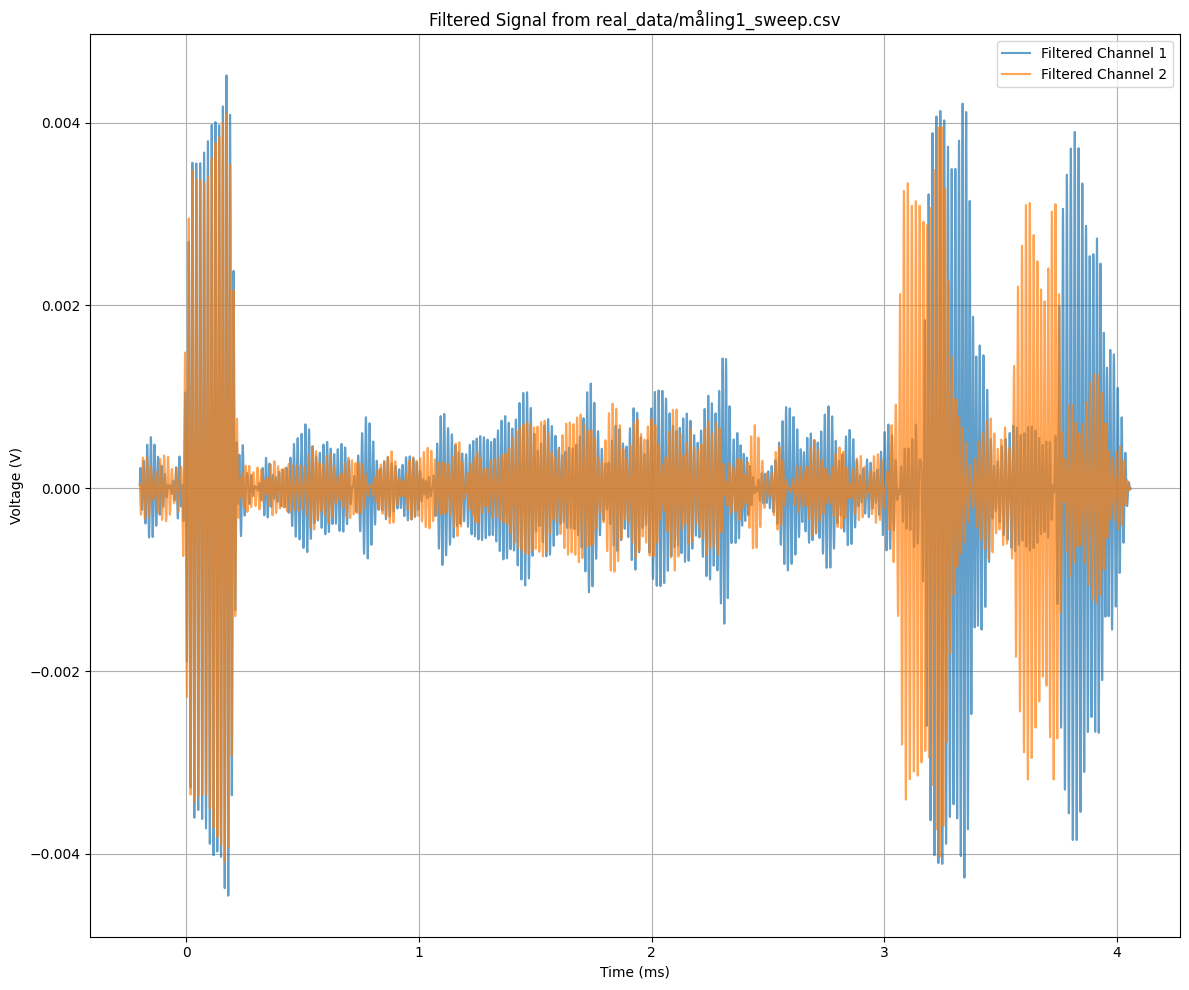

In [30]:
# Run some basic filtering on the signal
# We know that the frequency range we are operating on is from 57kHz to 72kHz ish, so lets just go 50 to 80 kHz
# passband
def bandpass_filter(data, fs, lowpass=50e3, highpass=80e3, order=4):
    nyquist = 0.5*fs
    low = lowpass / nyquist
    high = highpass / nyquist
    b, a = butter(order, [low, high], btype='band') 
    return filtfilt(b, a, data)

channel1 = bandpass_filter(channel1, fs)
channel2 = bandpass_filter(channel2, fs)
print(channel1)
print(channel2)

# Plot the filtered signals
plt.figure(figsize=(12, 10))
plt.plot(time * 1e3, channel1, label=f"Filtered Channel 1", alpha=0.7)
plt.plot(time * 1e3, channel2, label=f"Filtered Channel 2", alpha=0.7)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title(f"Filtered Signal from {files[0]}")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

1694
1694 16384
16384 16384


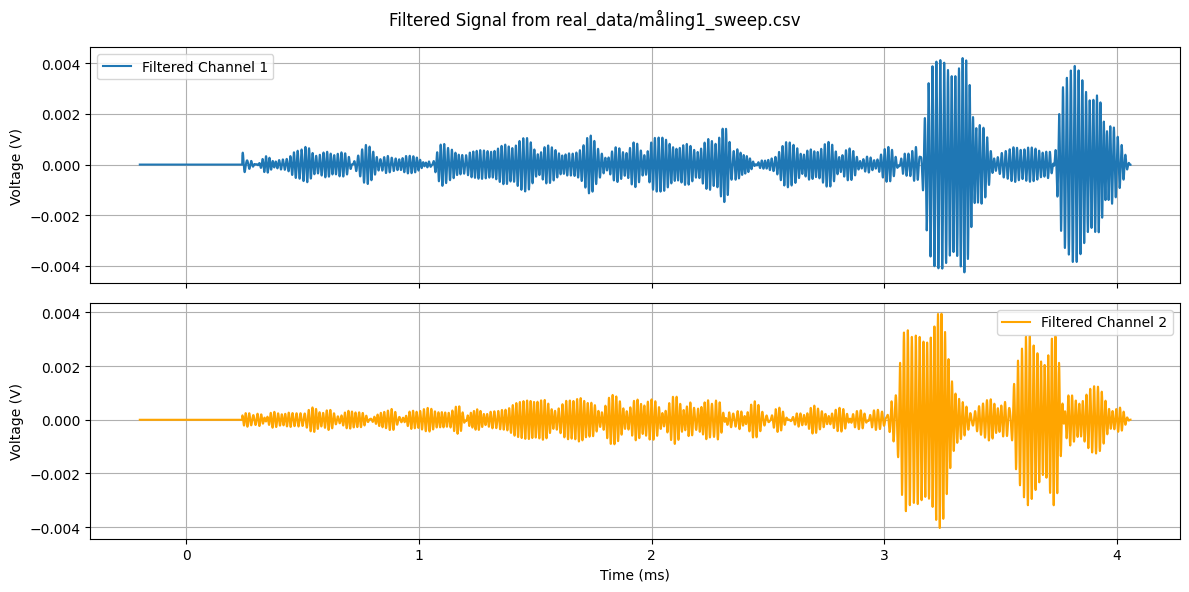

In [31]:
# First 200us of measured data has some emf bleedover from signal generation to transducer
# So just set the channel 1 and 2 values to zero
# t does not start at 0, so must figure out at what index t > 200us
cut_time_index = np.where(time > 200e-6 * 1.2)[0][0]  # +20% for good measure
print(cut_time_index)
print(cut_time_index, len(channel1))

channel1_trim = np.concatenate([np.zeros(cut_time_index), channel1[cut_time_index:]])
channel2_trim = np.concatenate([np.zeros(cut_time_index), channel2[cut_time_index:]])
print(len(time), len(channel1_trim))

# Plot the trimmed signals in vertically stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time * 1e3, channel1_trim, label="Filtered Channel 1")
axs[0].set_ylabel("Voltage (V)")
axs[0].legend()
axs[0].grid()

axs[1].plot(time * 1e3, channel2_trim, label="Filtered Channel 2", color='orange')
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Voltage (V)")
axs[1].legend()
axs[1].grid()

fig.suptitle(f"Filtered Signal from {files[0]}")
plt.tight_layout()
plt.savefig("figures/filtered_signal.png", dpi=300)
plt.show()

Estimated TDOA (H2 vs H1): 105.56 µs


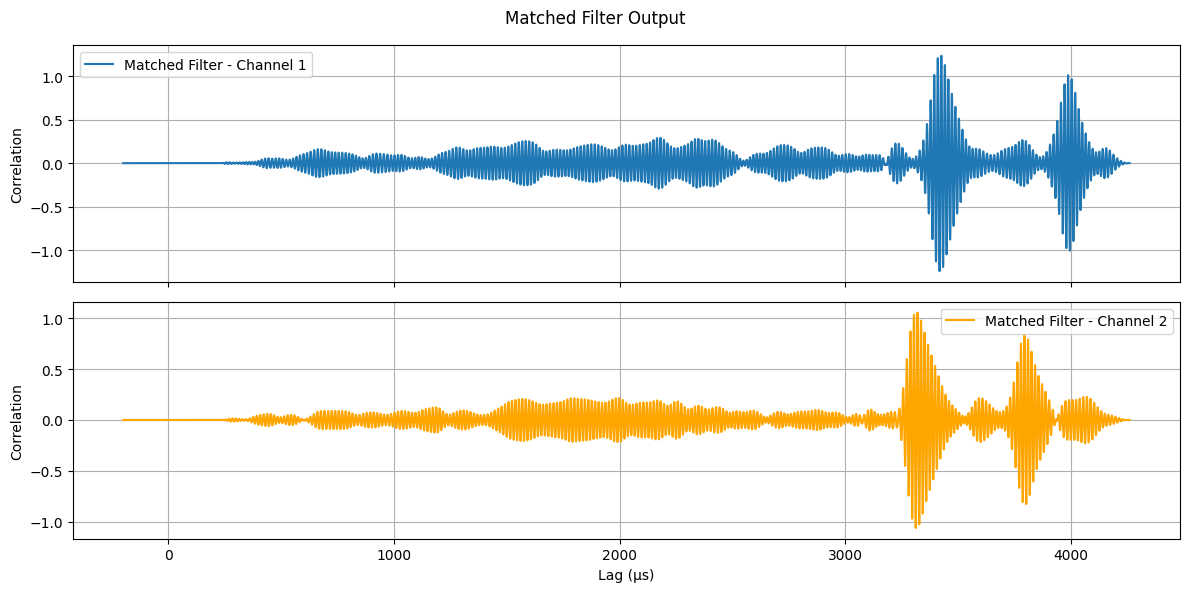

In [32]:
# Trying out matched filtering
T = 200e-6  # Duration of sweep
f0, f1 = 58e3, 72e3
ref_time = np.linspace(0, T, int(fs * T))
reference_chirp = chirp(ref_time, f0=f0, f1=f1, t1=T, method='linear')

# Example for burst 0
matched1 = correlate(channel1_trim, reference_chirp, mode='full')
matched2 = correlate(channel2_trim, reference_chirp, mode='full')

lags = np.arange(-len(reference_chirp) + 1, len(channel1_trim))

# Find peak positions
peak1 = np.argmax(np.abs(matched1))
peak2 = np.argmax(np.abs(matched2))

# TDOA in samples and seconds
delta_samples = peak1 - peak2
delta_time = delta_samples / fs
print(f"Estimated TDOA (H2 vs H1): {delta_time * 1e6:.2f} µs")

# Plot matched filter outputs in two stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(lags / fs * 1e6, matched1, label="Matched Filter - Channel 1")
#axs[0].axvline((delta_samples / fs) * 1e6, color='r', linestyle='--', label='Estimated TDOA')
axs[0].set_ylabel("Correlation")
axs[0].legend()
axs[0].grid()

axs[1].plot(lags / fs * 1e6, matched2, label="Matched Filter - Channel 2", color='orange')
#axs[1].axvline((delta_samples / fs) * 1e6, color='r', linestyle='--', label='Estimated TDOA')
axs[1].set_xlabel("Lag (µs)")
axs[1].set_ylabel("Correlation")
axs[1].legend()
axs[1].grid()

fig.suptitle("Matched Filter Output")
plt.tight_layout()
plt.savefig("figures/match_filtered_singal.png", dpi=300)
plt.show()

In [33]:
d = 0.4  # distance between hydrophones in meters
c = 1440  # speed of sound in water (m/s)

# Clamp sin(theta) to avoid invalid values due to noise
sin_theta = np.clip((delta_time-12e-6) * c / d, -1.0, 1.0)
aoa = np.arcsin(sin_theta) * 180 / np.pi
print(f"Estimated AoA: {aoa:.2f} degrees")

Estimated AoA: 19.68 degrees


In [34]:
# Estimate distance traveled
time_trav_channel2 = time[peak2] - T # account for peak being in middle of sweep
distance_peak2 = time_trav_channel2 * c
print(f"Time traveled: {time_trav_channel2*1000:.4f} ms. Distance traveled: {distance_peak2:.2f} m")

Time traveled: 3.1109 ms. Distance traveled: 4.48 m


In [35]:
# Hydrophone 2 position
hydrophone2_x = 2.13
hydrophone2_y = 0
hydrophone1_x = hydrophone2_x + 0.42
hydrophone1_y = 0

# Relative offset from hydrophone 2
x_rel = -distance_peak2 * np.sin(np.deg2rad(aoa))
y_rel = distance_peak2 * np.cos(np.deg2rad(aoa))

# Estimated position in global coordinates
x_est = x_rel + hydrophone1_x
y_est = y_rel + hydrophone1_y

print(f"Estimated source position: x = {x_est:.2f} m, y = {y_est:.2f} m")

# Optional: Append to a list for plotting later
estimated_position = (x_est, y_est)
print(estimated_position)

Estimated source position: x = 1.04 m, y = 4.22 m
(1.0411566764170388, 4.217972231450199)


Absolute distance off: 0.08416427779593827 m
Relative error: 1.88%


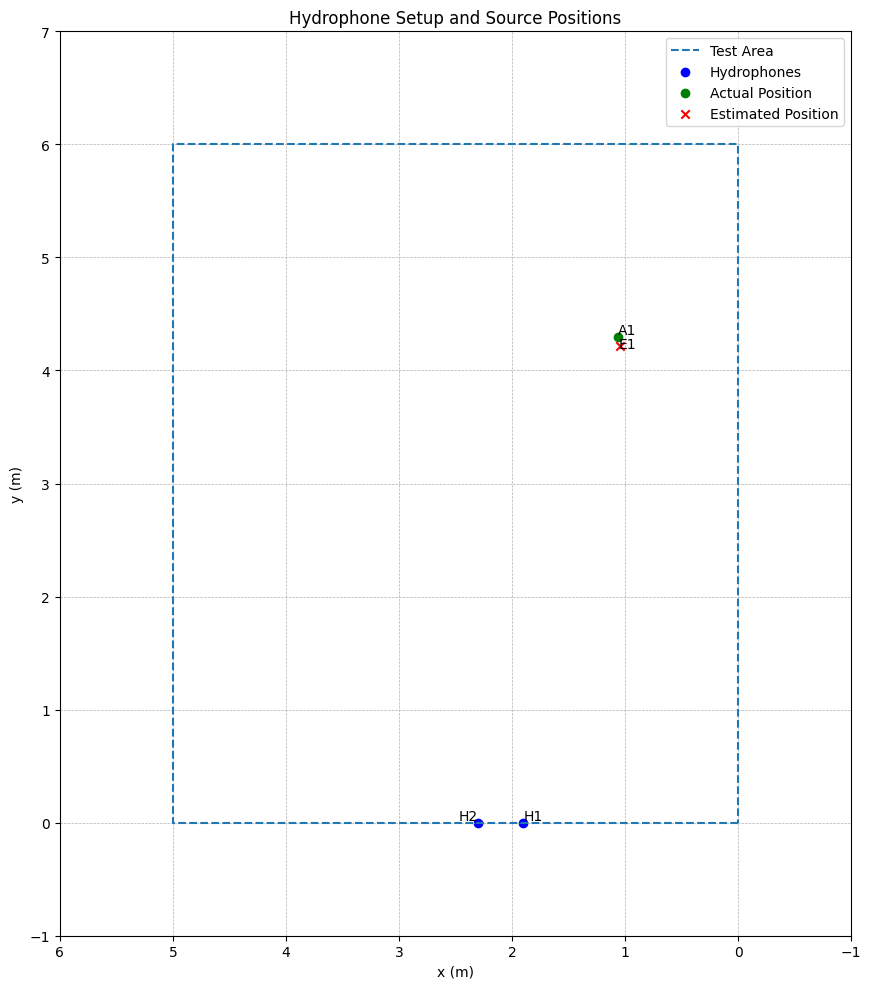

In [36]:
import matplotlib.pyplot as plt

# Room setup
room_width = 5  # meters (example)
room_height = 6  # meters (example)

# Hydrophone positions (centered along x-axis, 40 cm apart)
hydrophone_1 = (2.1 - 0.2, 0)
hydrophone_2 = (2.1 + 0.2, 0)

# Actual positions of the sound source (from measurements)  
x1 = 1.7 - 0.15
x2 = 1.7 - 0.64
actual_positions = [
    (x1, 3),
    (x1, 4.3),
    (x2, 4.3)
]

# Plotting
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')

# Draw rectangle for setup area
plt.plot([0, room_width, room_width, 0, 0], [0, 0, room_height, room_height, 0], '--', label='Test Area')

# Plot hydrophones
plt.scatter(*zip(hydrophone_1, hydrophone_2), color='blue', label='Hydrophones')
plt.text(*hydrophone_1, "H1", ha='left', va='bottom')
plt.text(*hydrophone_2, "H2", ha='right', va='bottom')

# Plot actual positions
for i, pos in enumerate(actual_positions[data_index:data_index+1]):
    plt.scatter(*pos, color='green', label='Actual Position' if i == 0 else "")
    plt.text(*pos, f"A{i+1}", va='bottom')

    diff = ((pos[0] - estimated_position[0])**2 + (pos[1] - estimated_position[1])**2)**0.5
    print(f"Absolute distance off: {diff} m")
    print(f"Relative error: {diff/distance_peak2 * 100:.2f}%")

# Plot estimated positions
plt.scatter(*estimated_position, color='red', marker='x', label='Estimated Position' if i == 0 else "")
plt.text(*pos, f"E{i+1}", va='top')

plt.title("Hydrophone Setup and Source Positions")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True, "both", linestyle="--", linewidth=0.5)
plt.legend(loc="upper right")
plt.xlim(room_width+1, -1)
plt.ylim(-1, room_height + 1)
plt.tight_layout()
plt.savefig("figures/estimated_position.png", dpi=300)
plt.show()